In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [3]:
df_filtered = pd.read_csv('events/df_filtered_reg.csv')

In [55]:
df_filtered = df_filtered[(df_filtered.cat != 'undefined') & (df_filtered.views_7_sum > 10) & (df_filtered.event_date > '2015-12-31')].drop_duplicates().copy()
df_filtered['GDP_pc_z'] = standardize_var(df_filtered, 'GDP_pc')
df_filtered['gdp_z'] = standardize_var(df_filtered, 'GDP')
df_filtered['pop_z'] = standardize_var(df_filtered, 'population')
df_filtered['views_baseline_z'] = standardize_var(df_filtered, 'views_baseline')
df_filtered['view_country_article_z'] = standardize_var(df_filtered, 'view_country_article')
df_filtered['bing_hits_z'] = standardize_var(df_filtered, 'bing_hits')
df_filtered['worldwide'] = df_filtered.code.apply(lambda c: (c == 'en') or (c=='es'))
df_filtered['view_country_article_log'] = np.log1p(df_filtered.view_country_article)
df_filtered['views_baseline_log'] = np.log1p(df_filtered.views_baseline)
df_filtered['bing_hits_log'] = np.log1p(df_filtered.bing_hits)
df_filtered['GDP_pc_log'] = np.log1p(df_filtered.GDP_pc)
df_filtered['GDP_log'] = np.log1p(df_filtered.GDP)
df_filtered['population_log'] = np.log1p(df_filtered.population)

baselines = {'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'North America', 'cat': 'sports', 'code': 'en', 'continent': 'North America', 'economic_region': 'Global North'} #{'gni_class': 'H', 'in_code_lang': True, 'gni_region': 'North America', 'cat': 'sports', 'code': 'en'},
cat_dict = {'en': 'English', 'it': 'Italian', 'es': 'Spanish', 'de': 'German', 'economic_region': 'Global North'}
label_renames = {'Middle East & North Africa': 'MENAf', 'Latin America & Caribbean': 'LatAmC',
               'Europe & Central Asia': 'EuCAs', 'East Asia & Pacific': 'EAsP', 'North America': 'NAm',
               'Sub-Saharan Africa': 'SSAf', 'South Asia': 'SAs', 'GDP_pc_z': 'GDP pc (z.)',
                 'GDP_pc_log': 'GDP pc', 'gni_class': 'Income', 'gni_region': 'Region',
                 'bing_hits_log': 'Bing News', 'view_country_article_log': 'Views to\nCountry\nArticle', 'views_baseline_log': 'Views\nfrom\nCountry',
                  'bing_hits_z': 'Bing (z)', 'view_country_article_z': 'Views to\nCountry\nArticle (z)', 'views_baseline_z': 'Views\nfrom\nCountry (z)',
                 'Global North': 'North', 'Global South': 'South', 'cat': 'Article Category', 
                 'South America': 'South Am.', 'population_log': 'Population'
                }
label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
              'cat': ['sports', 'disaster',
                      'culture', 'politics'],
              'gni_region': ['North America',
                             'Europe & Central Asia',
                             'Middle East & North Africa',
                             'East Asia & Pacific',
                             'South Asia',
                             'Latin America & Caribbean',
                             'Sub-Saharan Africa'],
           'continent': ['North America', 'Africa',  'Asia', 'Europe', 'Oceania', 'South America'],
           'economic_region': ['Global North', 'Global South']}


### Simple model dependent on GDP per capita

#### GDP log vs. gdp z-standardized

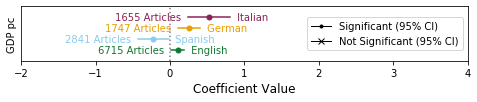

In [56]:
nb_fit_dict_0 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ GDP_pc_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_0, ['GDP_pc_log'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,1))

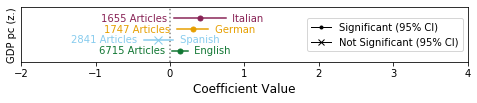

In [57]:
nb_fit_dict_0_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ GDP_pc_z', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_0_1, ['GDP_pc_z'], baselines,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,1))

### 1) Controlling for categories

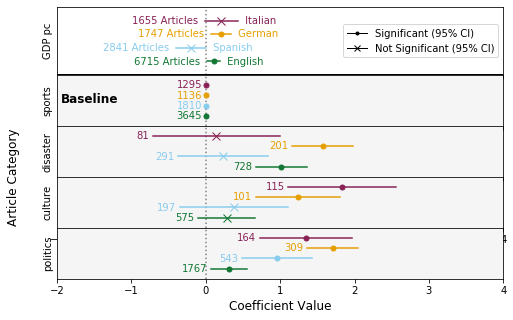

In [58]:
nb_fit_dict_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_1, ['GDP_pc_log', 'cat'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,5))

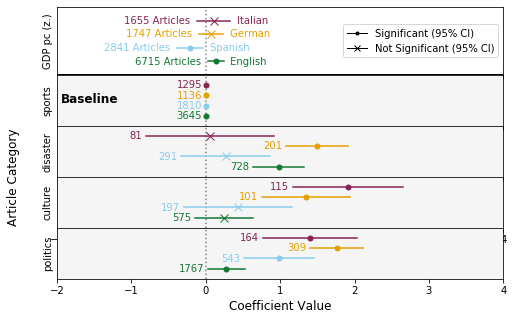

In [59]:
nb_fit_dict_1 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_z', est_method='lbfgs',
                                                   output_lvl=0)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_1, ['GDP_pc_z', 'cat'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,5))

## 2) Controlling for Country Attention
- Views to event country article (in Wikipedia language version) from any country
- Views from event country (to Wikipedia language version)

In [60]:
for code in df_filtered.code.unique():
    for cat in df_filtered.cat.unique():
        df_corr = df_filtered[(df_filtered.code==code) & (df_filtered.cat==cat)][['view_country_article', 'views_baseline']].corr('spearman')
        print(code, cat, 'corr: ', df_corr.loc['views_baseline', 'view_country_article'])

en disaster corr:  0.9245825574435137
en culture corr:  0.9459427263967491
en sports corr:  0.9152433814986102
en politics corr:  0.9745386382361759
de disaster corr:  0.9108007123390832
de culture corr:  0.9536577820079893
de sports corr:  0.9020304550004454
de politics corr:  0.8614941791420343
it disaster corr:  0.8935070980264548
it culture corr:  0.8424082260405081
it sports corr:  0.9166650872377369
it politics corr:  0.8873856818668413
es disaster corr:  0.9064126613529812
es culture corr:  0.5664181060495096
es sports corr:  0.8691010796648723
es politics corr:  0.9056319842094354


________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.26 (p=0.0001)
Deviance: 1633.61 | Null-deviance: 1748.56 | Pseudo R² (1 - D/D_0) = 0.0657
Pseudo ChiSq: 6650.26 | Good-Fit-ChiSq: 6900.66 | Residual DF: 6709
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.99
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 19.34 (p=0.0001)
Deviance: 574.61 | Null-deviance: 625.85 | Pseudo R² (1 - D/D_0) = 0.0819
Pseudo ChiSq: 2929.91 | Good-Fit-ChiSq: 2959.98 | Residual DF: 2835
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.03
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.45 (p=0.1464)
Deviance: 1278.51 |

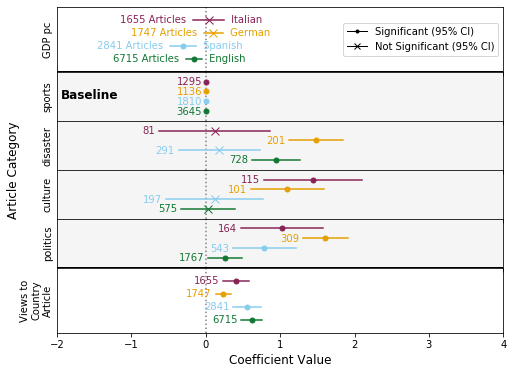

In [61]:
nb_fit_dict_2a = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log', est_method='lbfgs',
                                                   output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_2a, ['GDP_pc_log', 'cat', 'view_country_article_log'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,6))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.48 (p=0.0003)
Deviance: 1623.74 | Null-deviance: 1725.45 | Pseudo R² (1 - D/D_0) = 0.0590
Pseudo ChiSq: 7108.48 | Good-Fit-ChiSq: 6900.66 | Residual DF: 6709
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.06
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 20.63 (p=0.0032)
Deviance: 550.07 | Null-deviance: 586.80 | Pseudo R² (1 - D/D_0) = 0.0626
Pseudo ChiSq: 3641.08 | Good-Fit-ChiSq: 2959.98 | Residual DF: 2835
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.28
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.76 (p=0.1664)
Deviance: 1209.81 |

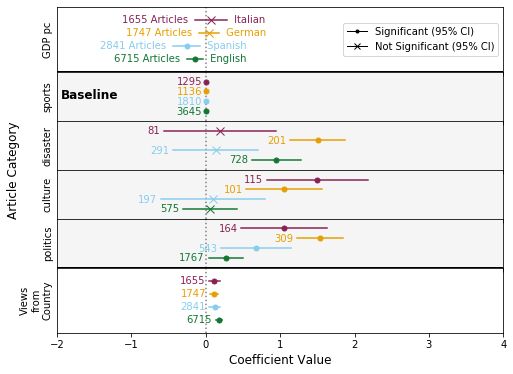

In [62]:
nb_fit_dict_2b = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + views_baseline_log', est_method='lbfgs',
                                                   output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_2b, ['GDP_pc_log', 'cat', 'views_baseline_log'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,6))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.26 (p=0.0001)
Deviance: 1633.31 | Null-deviance: 1748.97 | Pseudo R² (1 - D/D_0) = 0.0661
Pseudo ChiSq: 6766.87 | Good-Fit-ChiSq: 6899.65 | Residual DF: 6708
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.01
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 19.19 (p=0.0000)
Deviance: 578.96 | Null-deviance: 630.60 | Pseudo R² (1 - D/D_0) = 0.0819
Pseudo ChiSq: 2935.65 | Good-Fit-ChiSq: 2958.96 | Residual DF: 2834
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.04
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.46 (p=0.1450)
Deviance: 1271.16 |

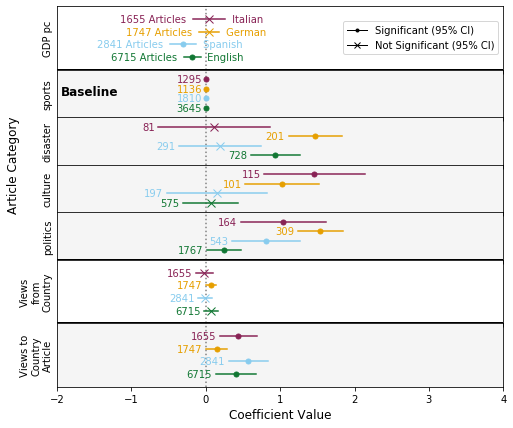

In [63]:
nb_fit_dict_2c = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + views_baseline_log', est_method='lbfgs',
                                                   output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_2c, ['GDP_pc_log', 'cat', 'views_baseline_log', 'view_country_article_log'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-2, 4), figsize=(8,7))

... thematically, there is a difference. Computationally, it is mostly the same: slight positive correlation with views_country_article having the higher coefficients and effect on the regression: Considering all performance metrics (deviance/r² and chi-square) the model using simply using the views to the country's article as a baseline seems to perform slightly better.

Using both does not bring any benefit to the model, considering r²/deviance.

Moving forward using only "views to the country's article" as the control.

## 3) Adding geographical factors 
Again, here we have multiple options:
- economic region (north/south)
- continents
- world-bank regional units (similar to continents but different grouping): https://www.worldbank.org/en/about/annual-report/region-perspectives


________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.98 (p=0.0001)
Deviance: 1649.66 | Null-deviance: 1779.21 | Pseudo R² (1 - D/D_0) = 0.0728
Pseudo ChiSq: 6744.25 | Good-Fit-ChiSq: 6894.58 | Residual DF: 6703
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.01
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 17.63 (p=0.0004)
Deviance: 615.63 | Null-deviance: 686.38 | Pseudo R² (1 - D/D_0) = 0.1031
Pseudo ChiSq: 3473.47 | Good-Fit-ChiSq: 2953.85 | Residual DF: 2829
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.23
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.36 (p=0.1070)
Deviance: 1274.67 |

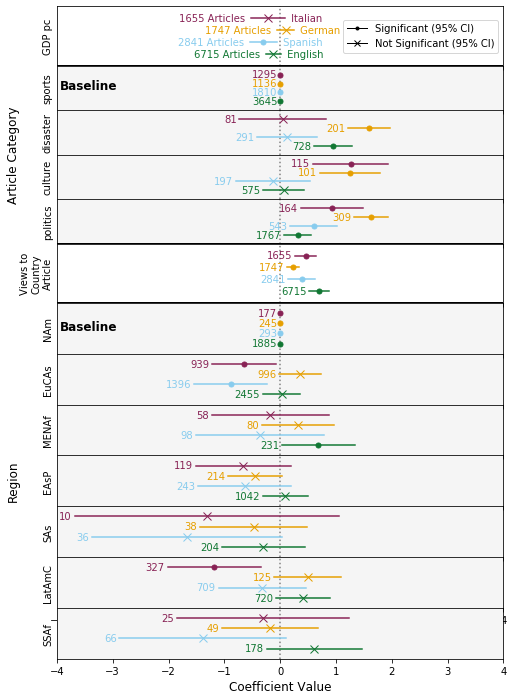

In [64]:
nb_fit_dict_3a = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered,
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log +  C(gni_region, Treatment(reference="North America"))', est_method='lbfgs',
     output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_3a, ['GDP_pc_log', 'cat', 'view_country_article_log', 'gni_region'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-4, 4), figsize=(8,12))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.03 (p=0.0002)
Deviance: 1647.88 | Null-deviance: 1774.14 | Pseudo R² (1 - D/D_0) = 0.0712
Pseudo ChiSq: 7159.58 | Good-Fit-ChiSq: 6895.59 | Residual DF: 6704
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.07
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 17.73 (p=0.0014)
Deviance: 614.40 | Null-deviance: 682.72 | Pseudo R² (1 - D/D_0) = 0.1001
Pseudo ChiSq: 3705.75 | Good-Fit-ChiSq: 2954.87 | Residual DF: 2830
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.31
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.31 (p=0.1070)
Deviance: 1277.98 |

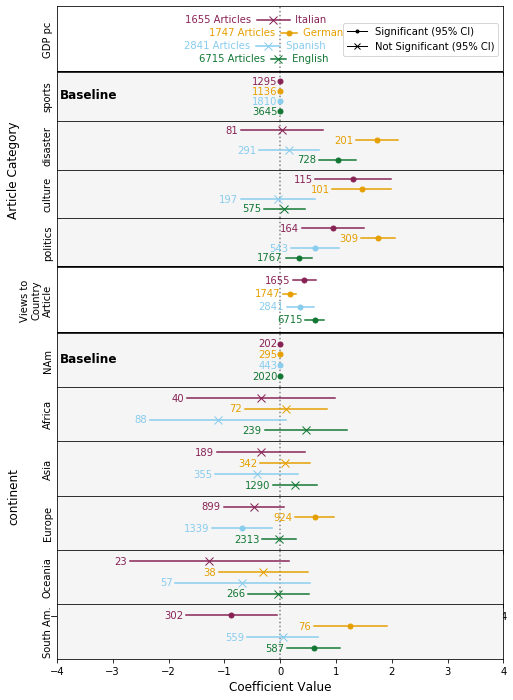

In [65]:
nb_fit_dict_3b = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered, 
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + C(continent, Treatment(reference="North America"))', est_method='lbfgs',
    output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_3b, ['GDP_pc_log', 'cat', 'view_country_article_log', 'continent'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-4, 4), figsize=(8,12))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.20 (p=0.0002)
Deviance: 1635.70 | Null-deviance: 1755.12 | Pseudo R² (1 - D/D_0) = 0.0680
Pseudo ChiSq: 6914.77 | Good-Fit-ChiSq: 6899.65 | Residual DF: 6708
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.03
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 18.94 (p=0.0009)
Deviance: 583.95 | Null-deviance: 639.05 | Pseudo R² (1 - D/D_0) = 0.0862
Pseudo ChiSq: 3327.69 | Good-Fit-ChiSq: 2958.96 | Residual DF: 2834
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.17
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.46 (p=0.1455)
Deviance: 1275.99 |

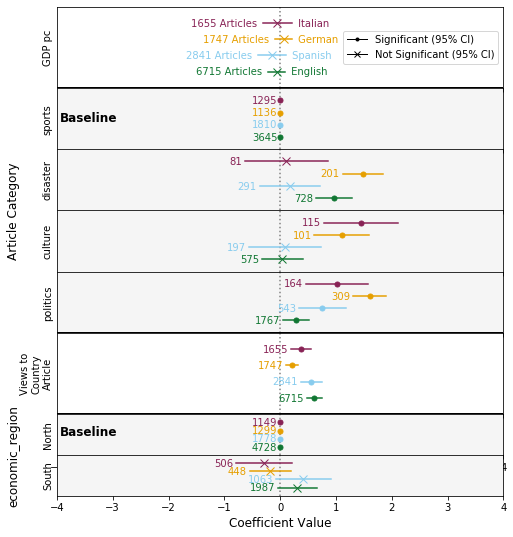

In [66]:
nb_fit_dict_3c = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_filtered, 'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + economic_region', est_method='lbfgs',
                                                   output_lvl=1)
fig_vis = plot_regression_results_from_dict(df_filtered, nb_fit_dict_3c, ['GDP_pc_log', 'cat', 'view_country_article_log', 'economic_region'], baselines, label_sort=label_sort,
                                  cat_dict=cat_dict,  label_rename_dict=label_renames, include_counts=True, x_limits=(-4, 4), figsize=(8,9))

Takeaway: Similar as in the view-baselines discussed in 2), it doesn't matter so much from a results standpoint - it depends more on what we actually would want to discuss in the paper.

- Do we want a strict geographical standpoint (continents)? Or do we want to group "similar" geographic regions together? (world-bank regions)

No matter which grouping, all country groupings might bear some economic information, which might take away from the gdp a bit.  

## 4) More comprehensive model

we could now attempt to also use other infos, like the event-countries population or bing news hits. The correlation and VIF for these parameters seem to indicate no (or little) correlation with the other parameters used so far.

#### include population

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.26 (p=0.0001)
Deviance: 1631.34 | Null-deviance: 1748.53 | Pseudo R² (1 - D/D_0) = 0.0670
Pseudo ChiSq: 6547.10 | Good-Fit-ChiSq: 6899.65 | Residual DF: 6708
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.98
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 19.16 (p=0.0000)
Deviance: 577.41 | Null-deviance: 631.57 | Pseudo R² (1 - D/D_0) = 0.0857
Pseudo ChiSq: 2710.98 | Good-Fit-ChiSq: 2958.96 | Residual DF: 2834
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.96
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.29 (p=0.1377)
Deviance: 1302.84 |

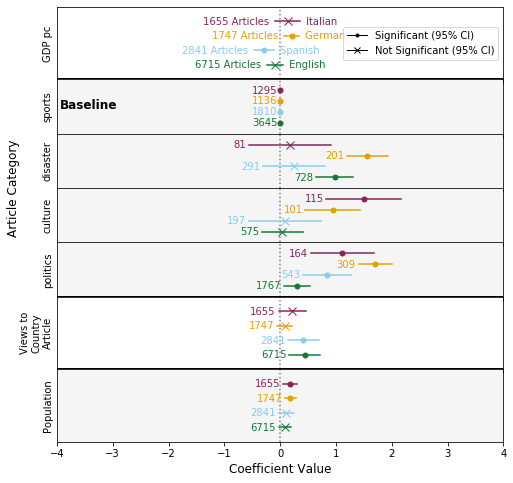

In [67]:
# no geographic region
nb_fit_dict_4a = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered,
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + population_log', est_method='lbfgs',
     output_lvl=1)
fig_vis = plot_regression_results_from_dict(
    df_filtered, nb_fit_dict_4a, 
    ['GDP_pc_log', 'cat', 'view_country_article_log', 'population_log'], 
    baselines, label_sort=label_sort, cat_dict=cat_dict,  label_rename_dict=label_renames, 
    include_counts=True, x_limits=(-4, 4), figsize=(8,8))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.96 (p=0.0001)
Deviance: 1650.29 | Null-deviance: 1781.66 | Pseudo R² (1 - D/D_0) = 0.0737
Pseudo ChiSq: 6655.60 | Good-Fit-ChiSq: 6893.56 | Residual DF: 6702
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.99
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 17.40 (p=0.0001)
Deviance: 620.96 | Null-deviance: 695.68 | Pseudo R² (1 - D/D_0) = 0.1074
Pseudo ChiSq: 3382.24 | Good-Fit-ChiSq: 2952.83 | Residual DF: 2828
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.20
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 5.08 (p=0.0543)
Deviance: 1307.12 |

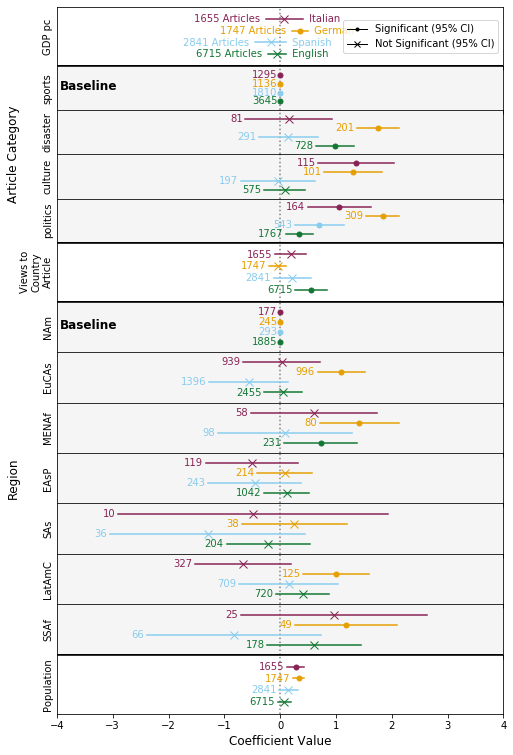

In [68]:
# with geographic region
nb_fit_dict_4b = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered,
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log +  C(gni_region, Treatment(reference="North America")) + population_log', est_method='lbfgs',
     output_lvl=1)
fig_vis = plot_regression_results_from_dict(
    df_filtered, nb_fit_dict_4b, 
    ['GDP_pc_log', 'cat', 'view_country_article_log', 'gni_region', 'population_log'], 
    baselines, label_sort=label_sort, cat_dict=cat_dict,  label_rename_dict=label_renames, 
    include_counts=True, x_limits=(-4, 4), figsize=(8,13))

#### Include bing hits as well 

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.05 (p=0.0008)
Deviance: 1728.06 | Null-deviance: 1889.06 | Pseudo R² (1 - D/D_0) = 0.0852
Pseudo ChiSq: 6969.86 | Good-Fit-ChiSq: 6898.64 | Residual DF: 6707
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.04
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 15.44 (p=0.0000)
Deviance: 667.90 | Null-deviance: 783.85 | Pseudo R² (1 - D/D_0) = 0.1479
Pseudo ChiSq: 2642.52 | Good-Fit-ChiSq: 2957.94 | Residual DF: 2833
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.93
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 3.93 (p=0.0049)
Deviance: 1438.76 |

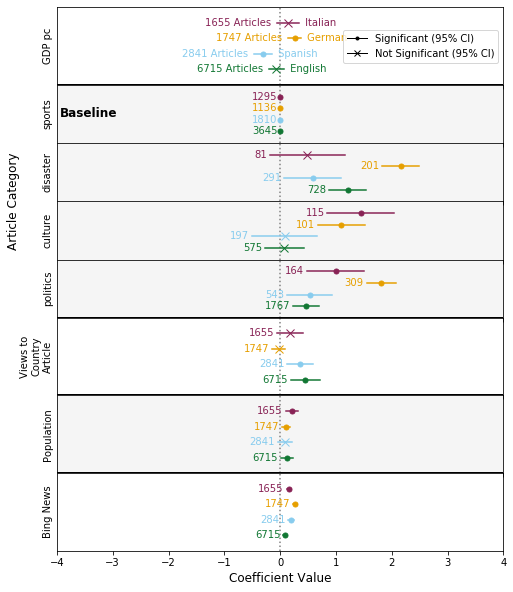

In [69]:
# with geographic region
nb_fit_dict_4c = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered,
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log + population_log + bing_hits_log', est_method='lbfgs',
     output_lvl=1)
fig_vis = plot_regression_results_from_dict(
    df_filtered, nb_fit_dict_4c, 
    ['GDP_pc_log', 'cat', 'view_country_article_log', 'population_log', 'bing_hits_log'], 
    baselines, label_sort=label_sort, cat_dict=cat_dict,  label_rename_dict=label_renames, 
    include_counts=True, x_limits=(-4, 4), figsize=(8,10))

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 14.70 (p=0.0007)
Deviance: 1758.67 | Null-deviance: 1934.80 | Pseudo R² (1 - D/D_0) = 0.0910
Pseudo ChiSq: 7172.71 | Good-Fit-ChiSq: 6892.55 | Residual DF: 6701
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.07
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 14.10 (p=0.0000)
Deviance: 716.42 | Null-deviance: 858.62 | Pseudo R² (1 - D/D_0) = 0.1656
Pseudo ChiSq: 3191.86 | Good-Fit-ChiSq: 2951.81 | Residual DF: 2827
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.13
________________________________________________________________________________________________
================= Fitting de =================
Estimated alpha as 3.82 (p=0.0002)
Deviance: 1460.30 |

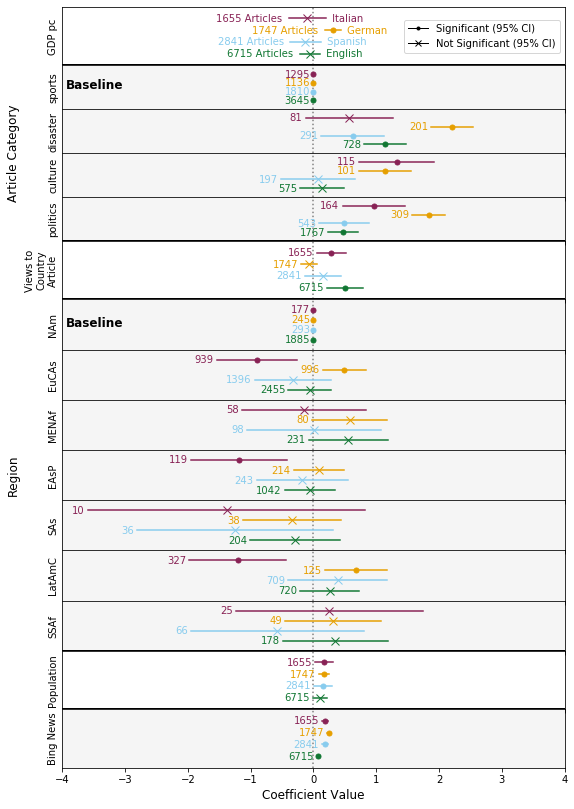

In [71]:
# with geographic region
nb_fit_dict_4d = fit_nb_with_estimated_alpha_all_codes(
    ['en', 'es', 'de', 'it'], df_filtered,
    'views_7_sum ~ C(cat, Treatment(reference="sports")) + GDP_pc_log + view_country_article_log +  C(gni_region, Treatment(reference="North America")) + population_log + bing_hits_log', est_method='lbfgs',
     output_lvl=1)
fig_vis = plot_regression_results_from_dict(
    df_filtered, nb_fit_dict_4d, 
    ['GDP_pc_log', 'cat', 'view_country_article_log', 'gni_region', 'population_log', 'bing_hits_log'], 
    baselines, label_sort=label_sort, cat_dict=cat_dict,  label_rename_dict=label_renames, 
    include_counts=True, x_limits=(-4, 4), figsize=(9,14))

#### Final remarks
- Bing news hits greatly increases the performance of the model. However, we must consider our measurement of bing news hits is not THAT sophisticated (and we didn't scale for years - however that might not matter as our events are at least 1 year back.


In [ ]:
... In the end, 